# Split Apply Combine

See:
* https://www.jstatsoft.org/article/view/v040i01/v40i01.pdf

## Imports etc

In [68]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Theory

The idea behind this is that much of data analysis can be described by a three step process:
1. Split the data into groups
2. Apply a function to each group
3. Combine the results from each group back into a data structure

For example, let's say we want to see if galaxy color is correlated with morphology. We would,
1. Split the data into separate groups by morphology (spirals, ellipticals, etc)
2. Compute the mean of the color for each of these groups
3. Collate those results in a table.

This seems simple, and I think it actually is (I might be missing a ton of subtlety or power though)...
But, despite (or perhaps because of) the simplicity, if we look out for this pattern we find that it can be applied to many different problems.
This is good news because there are great libraries that do this for us! So, if we can frame our problem as a SAC problem, we can solve it without writing much code! (in the same spirit as the [SAT solver talk](https://rhettinger.github.io/))?

In Python that library is going to be pandas. However, note that SAC is pretty much just SQL's `GROUP BY` (and in fact the function in pandas that does it is also called `groupby`). So another (language independent) alternative is to dump your data in a SQLite DB and use that!

Let's see some examples.

## Simple example

This data is the sklearn diabetes dataset, though without the preprocessing sklearn has applied that makes it impossible to understand...

In [23]:
df = pd.read_csv("diabetes.csv", delimiter="\t", comment="#")
df.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


What might we want to do? Let's see how things vary across the sexes.

In [39]:
# Do the split - this returns a 'DataFrameGroupBy' objects
grouped = df.groupby("SEX")
print(type(grouped))

# Do a apply. For now, let's just look at the means of the columns.
# Returns a DataFrame (so this also does the combine
means = grouped.mean()
print(type(means))

# In general we will do these all at once 
means = df.groupby("SEX").mean()
means.head()

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>
<class 'pandas.core.frame.DataFrame'>


,AGE,BMI,BP,S1,S2,S3,S4,S5,S6,Y
SEX,,,,,,,,,,
1,46.382979,26.010638,91.521957,187.995745,111.372340,54.385106,3.668468,4.567993,89.017021,149.021277
2,50.942029,26.790338,98.194783,190.439614,120.056039,44.570048,4.526377,4.724760,93.806763,155.666667


This is telling us that sex 2 sees more progression (larger Y). But the sample of this sex is older. Maybe the progression is just due to age. Let's group both by age and sex.

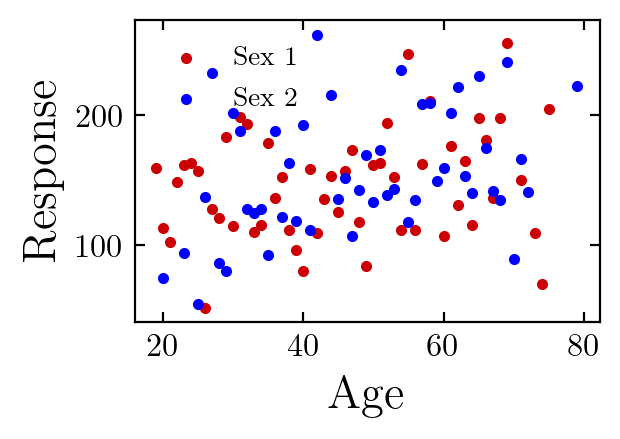

In [71]:
# It doesn't really matter which order we put these. Though it does change the multiIndex order
means = df.groupby(["SEX", "AGE"]).mean()
means.head()

_, ax = plt.subplots(figsize=mpl.small_plotsize)
ax.scatter(means.loc[1].index, means.loc[1]["Y"], label="Sex 1")
ax.scatter(means.loc[2].index, means.loc[2]["Y"], label="Sex 2")
ax.set(xlabel="Age", ylabel="Response")
ax.legend(fontsize="x-small")

There does appear to be some dependence on age. Hard to see whether that accounts for the difference between the sexes... We'd need to compare regression lines or something. But we're not here to learn about diabetes. We're here to learn about SAC.

## More detailed Pandas things

Pandas has a large number of [functions](https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html) that can be applied directly. However, if it doesn't have what you want you can manually iterate over the groups. Or you can use the [aggregation api](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#basics-aggregate).

In [113]:
grouped = df.groupby(["AGE"])

mean1 = grouped.aggregate("mean")
mean2 = grouped.aggregate(np.mean)
pd.testing.assert_frame_equal(mean1, mean2) # These are identical

# Gets passed each group in turn. Needs to return a single row!
def myfunc(x):
    return np.mean(x)

mean3 = grouped.aggregate(myfunc)
pd.testing.assert_frame_equal(mean2, mean3) # As is using myfunc